In [2]:
from typing import *
from pathlib import Path

import torch
import torchmetrics
import pytorch_lightning as pl
import pytorch_lightning.callbacks as pl_callbacks
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset, Subset
from sklearn import preprocessing
from sklearn.model_selection import KFold

In [3]:
class SegmentDataset(Dataset):
    def __init__(self, data_dir: str = './'):
        self.data_dir = data_dir
        self.n_classes = 7
        self.label_encoder = preprocessing.LabelEncoder()
        self.scaler = preprocessing.StandardScaler()

        df = pd.read_csv(Path(self.data_dir) / 'segment.csv')
        targets = df.pop('class')
        self.features = pd.DataFrame(self.scaler.fit_transform(df), columns=df.columns).astype(np.float32)
        self.targets = pd.DataFrame(self.label_encoder.fit_transform(targets))

    def __getitem__(self, idx):
        return self.features.iloc[idx].to_numpy(), self.targets.iloc[idx][0] # type: ignore

    def __len__(self):
        return len(self.features)

def kfold(dataset: Dataset, n_folds: int):
    length = len(dataset) # type: ignore
    splits = list(KFold(n_splits=n_folds, shuffle=True, random_state=42).split(range(length)))
    return [(Subset(dataset, train_indices), Subset(dataset, test_indices)) for train_indices, test_indices in splits]

class TransformDataset(Dataset):
    def __init__(self, dataset: Dataset, transform):
        self.dataset = dataset
        self.transform = transform

    def __getitem__(self, idx):
        return self.transform(self.dataset[idx])
    
    def __len__(self):
        return len(self.dataset) # type: ignore

class EnumerateDataset(Dataset):
    def __init__(self, dataset: Dataset):
        self.dataset = dataset
    
    def __getitem__(self, idx):
        return idx, self.dataset[idx]
    
    def __len__(self):
        return len(self.dataset) # type: ignore

In [4]:
class SegmentModel(pl.LightningModule):
    def __init__(self, hidden_dim: int = 10, num_classes: int = 7):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.num_classes = num_classes
        self.model = torch.nn.Sequential(
            torch.nn.Linear(19, hidden_dim),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_dim, num_classes),
            torch.nn.Softmax(dim=1)
        )
        # self.loss = F.nll_loss
        self.loss = torch.nn.CrossEntropyLoss()
        self.accuracy = torchmetrics.Accuracy()

    def configure_optimizers(self):  # type: ignore
        return torch.optim.Adam(self.parameters(), lr=0.007)

    def forward(self, x): # type: ignore
        return self.model(x)

    def _get_metrics(self, batch):
        x, y = batch
        logits = self(x)
        loss = self.loss(logits, y)
        preds = torch.argmax(logits, dim=1)
        acc = self.accuracy(preds, y)
        return logits, loss, acc

    def training_step(self, batch, batch_idx): #type: ignore
        _, loss, acc = self._get_metrics(batch)
        self.log('train_loss', loss, on_step=True, on_epoch=True)
        self.log('train_acc', acc, on_step=True, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx): # type: ignore
        _, loss, acc = self._get_metrics(batch)
        self.log('val_loss', loss, prog_bar=True)
        self.log('val_acc', acc, prog_bar=True)
        return loss

    def test_step(self, batch, batch_idx): # type: ignore
        _, loss, acc = self._get_metrics(batch)
        self.log('test_loss', loss)
        self.log('test_acc', acc)
        return loss

In [5]:
# Some things we will reuse a couple of times
TrainDataLoader = lambda ds: DataLoader(ds, batch_size=256, shuffle=True, num_workers=4)
TestDataLoader = lambda ds: DataLoader(ds, batch_size=1024, shuffle=False, num_workers=4)
Trainer = lambda kwargs={}: pl.Trainer(
        accelerator='cpu',
        max_epochs=15,
        log_every_n_steps=5,
        enable_model_summary=False,
        callbacks=[pl_callbacks.TQDMProgressBar(refresh_rate=0)],
        **kwargs
)

In [6]:
ds = EnumerateDataset(SegmentDataset())
n_folds = 4
folds = kfold(ds, n_folds)
models = []
for (train_ds, test_ds) in folds:
    # Remove idx from the instances (we don't need it for training).
    remove_idx = lambda idx_inst: idx_inst[1]
    train_ds = TransformDataset(train_ds, remove_idx)
    test_ds = TransformDataset(test_ds, remove_idx)
    print(len(train_ds), len(test_ds))

    model = SegmentModel()
    trainer = Trainer()
    trainer.fit(model, TrainDataLoader(train_ds), TestDataLoader(test_ds))
    trainer.test(model, TestDataLoader(test_ds))
    models.append(model)

GPU available: True, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


1732 578


/home/wout/pp/22_AAAI_Assessors/.venv/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:1814: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=2)`.
  rank_zero_warn(
GPU available: True, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc             0.858131468296051
        test_loss           1.3400359153747559
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
1732 578


GPU available: True, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.8737024068832397
        test_loss            1.333388090133667
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
1733 577


GPU available: True, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.8873483538627625
        test_loss           1.3248142004013062
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
1733 577
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.8648180365562439
        test_loss            1.356109619140625
──────────────────────────────────────────────────────────────────────────────────────────────────────────────

## Create Dataset of Evaluation Results

In [7]:
trainer = pl.Trainer(callbacks=[pl_callbacks.TQDMProgressBar(refresh_rate=0)], max_epochs=1)
results_buffer = [] 
for syst_id, (model, (train_ds, test_ds)) in enumerate(zip(models, folds)):
    select_idx = lambda idx_inst: idx_inst[0]
    select_features = lambda idx_inst: idx_inst[1][0]
    select_target = lambda idx_inst: idx_inst[1][1]

    predict_ds = TransformDataset(test_ds, select_features)
    predictions: Any = trainer.predict(model, TestDataLoader(predict_ds))[0] # type: ignore

    df = pd.DataFrame({
        "syst_id": syst_id,
        "idx"    : list(TransformDataset(test_ds, select_idx)),       # type: ignore
        "y"      : list(TransformDataset(test_ds, select_target)), # type: ignore
        "y_hat"  : torch.argmax(predictions, dim=1),
        "conf"   : torch.max(predictions, dim=1)[0],
    })

    df['score'] = df.apply(lambda row: int(row.y == row.y_hat), axis=1)
    results_buffer.append(df)

results: pd.DataFrame = pd.concat(results_buffer, ignore_index=True) # type: ignore
print(results)

GPU available: True, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


      syst_id   idx  y  y_hat      conf  score
0           0     8  2      2  0.996818      1
1           0    13  4      4  0.978569      1
2           0    18  1      1  0.863898      1
3           0    23  5      5  0.993946      1
4           0    25  6      6  0.927302      1
...       ...   ... ..    ...       ...    ...
2305        3  2284  4      4  0.992281      1
2306        3  2291  0      0  0.533669      1
2307        3  2292  4      4  0.977775      1
2308        3  2294  0      0  0.729735      1
2309        3  2309  0      0  0.609059      1

[2310 rows x 6 columns]


In [8]:
class EvalResultDataset(Dataset):
    def __init__(self, df: pd.DataFrame, base: Dataset):
        self.df = df
        self.base = base

    def __getitem__(self, idx):
        inst = self.base[self.df['idx'].iloc[idx]]
        inst_features = inst[1][0]
        syst_id = self.df['syst_id'].iloc[idx]
        score = self.df['score'].iloc[idx]
        return syst_id, inst_features, score

    def __len__(self):
        return len(self.df)

results_train: Any = results.sample(frac=0.8, random_state=42) 
results_test: Any = results.drop(results_train.index)
assr_train_ds = EvalResultDataset(results_train, ds)
assr_test_ds = EvalResultDataset(results_test, ds)
print(len(results), len(assr_train_ds), len(assr_test_ds))
print(assr_train_ds[0])

2310 1848 462
(2, array([-1.1504388e+00, -8.4245920e-01,  0.0000000e+00, -3.5704732e-01,
        4.3913097e+00,  5.0012369e+00,  2.9946375e-01,  6.7011242e+00,
        3.9915627e-01,  4.7024566e-01,  4.1745442e-01,  4.8845318e-01,
        4.9414274e-01, -8.6139309e-01,  5.0718838e-01,  4.4435672e-03,
        4.7321752e-01, -5.6554359e-01, -6.4327013e-01], dtype=float32), 1)


## Define the Assessor model

In [45]:
class SegmentAssessorModel(pl.LightningModule):
    def __init__(self, hidden_dim: int = 10):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.model = torch.nn.Sequential(
            torch.nn.Linear(19+1, hidden_dim),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_dim, 1),
            torch.nn.Sigmoid()
        )
        loss = torch.nn.BCELoss(reduction='mean')
        self.loss = lambda input, target: loss(input, target.unsqueeze(-1).float())
        self.accuracy = torchmetrics.Accuracy()

    def configure_optimizers(self):  # type: ignore
        return torch.optim.Adam(self.parameters(), lr=0.007)

    def forward(self, *args):
        syst_id, x = args
        x = torch.column_stack((x, syst_id))
        return self.model(x)

    def _get_metrics(self, batch):
        syst_id, x, y = batch
        logits = self(syst_id, x)

        loss = self.loss(logits, y)
        # Cross entropy
        # preds = torch.argmax(logits, dim=1)
        # acc = self.accuracy(preds, y)
    
        # Binary Cross Entropy
        acc = self.accuracy(logits.squeeze(), y)
        return logits, loss, acc

    def training_step(self, batch, _): #type: ignore
        _, loss, acc = self._get_metrics(batch)
        self.log('train_loss', loss, on_step=True, on_epoch=True)
        self.log('train_acc', acc, on_step=True, on_epoch=True)
        return loss

    def validation_step(self, batch, _): # type: ignore
        _, loss, acc = self._get_metrics(batch)
        self.log('val_loss', loss, prog_bar=True)
        self.log('val_acc', acc, prog_bar=True)
        return loss

    def test_step(self, batch, _): # type: ignore
        _, loss, acc = self._get_metrics(batch)
        self.log('test_loss', loss)
        self.log('test_acc', acc)
        return loss

    def predict_step(self, batch, _): # type: ignore
        syst_id, x, = batch
        return self(syst_id, x)

## Train the Assessor model

In [46]:
assessor = SegmentAssessorModel()
trainer = Trainer()
trainer.fit(assessor, TrainDataLoader(assr_train_ds), TestDataLoader(assr_test_ds))
trainer.test(assessor, TestDataLoader(assr_test_ds))

GPU available: True, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.8766233921051025
        test_loss           0.2945426404476166
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.2945426404476166, 'test_acc': 0.8766233921051025}]

## Plot results

In [47]:
# Get assessor confidence for each instance
predict_ds = TransformDataset(assr_test_ds, lambda id_x_score: id_x_score[:2])
assr_preds = trainer.predict(assessor, TestDataLoader(predict_ds))[0] # type: ignore
assr_conf = torch.max(assr_preds, dim=1)[0] # type: ignore

# Put it together with the system results
df = results_test.copy()
df['assr_conf'] = assr_conf

# And select the results for a specific system we care about
df = df[df.syst_id == 0]
len(df)

99

Test instances shared between assessor and system x: 99


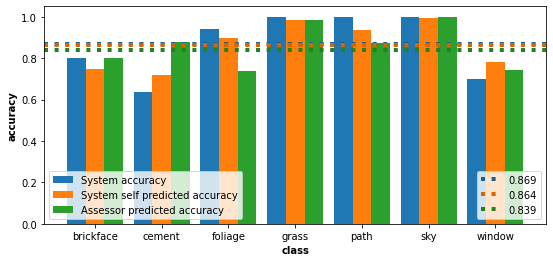

In [48]:
labels = SegmentDataset().label_encoder.classes_

def calc_stats(df):
    print(f"Test instances shared between assessor and system x:", len(df))
    return {
        "global": {
            "system_acc": df.score.mean(),
            "system_predicted_acc": df.conf.mean(),
            "assessor_predicted_acc": df.assr_conf.mean()
        },
        "per_class": {
            "system_acc": df.groupby(['y']).score.mean().to_list(),
            "system_predicted_acc": df.groupby(['y']).conf.mean().to_list(),
            "assessor_predicted_acc": df.groupby(['y']).assr_conf.mean().to_list()
        }
    }

import colorsys
def lighten(rgb, scale):
    h, l, s = colorsys.rgb_to_hls(*rgb[:-1])
    return colorsys.hls_to_rgb(h, min(1, l * scale), s=s)

def plot_stats(stats):
    fig, ax = plt.subplots(figsize=(9, 4))
    x = np.arange(len(labels))
    width = 0.28

    # Plot per-class bars
    per_class = stats['per_class']
    b1 = ax.bar(x - width * 1, per_class['system_acc'], width, label="System accuracy")
    b2 = ax.bar(x - width * 0.0, per_class['system_predicted_acc'],width,label="System self predicted accuracy")
    b3 = ax.bar(x + width * 1,per_class['assessor_predicted_acc'],width,label="Assessor predicted accuracy")
    
    # Draw horizontal lines for global accs
    corresponding_color = lambda bar: lighten(bar.patches[0].get_facecolor(), 0.8)
    def draw_hline(y, color, with_diff=False):
        label = f"{y:.3f}"
        line = ax.axhline(y, ls="dotted", lw=4, c=color, label=label)
        return line
    l1 = draw_hline(stats["global"]['system_acc'], corresponding_color(b1))
    l2 = draw_hline(stats["global"]['system_predicted_acc'], corresponding_color(b2))
    l3 = draw_hline(stats["global"]['assessor_predicted_acc'], corresponding_color(b3))

    # Style plot
    ax.set_xlabel("class", fontweight="bold")
    ax.set_ylabel("accuracy", fontweight="bold")
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    line_legend = ax.legend(handles=[l1, l2, l3], loc="lower right")
    ax.add_artist(line_legend)
    ax.legend(loc="lower left", handles=[b1, b2, b3])

stats = calc_stats(df)
plot_stats(stats)